# **RAG UsingWeaviate**

## **Roman Empire Question Answering System**
### **Overview**
This project is a question answering system focused on providing answers related to the Roman Empire. It utilizes various technologies such as Weaviate for document storage and similarity search, OpenAI for language models and embeddings, and Langchain for creating the question answering pipeline.
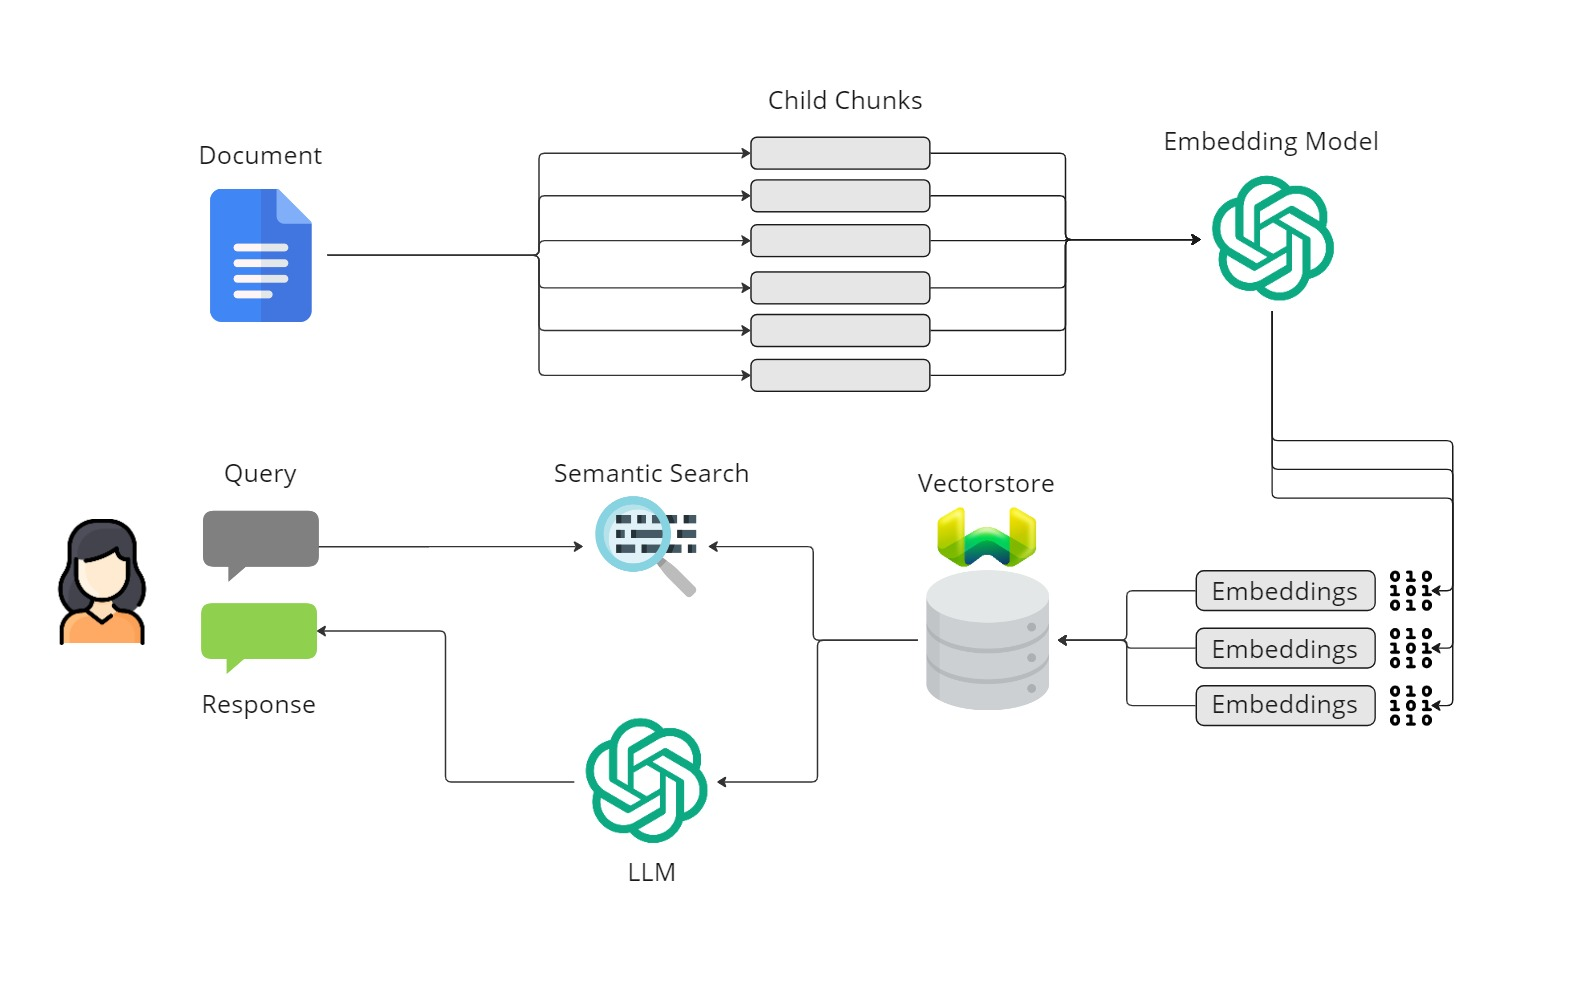

**Setup Instructions:**
- Install All the required libraries and dependencies.
- Define your Weaviate and OpenAI credentials.
- load the documents using the `load_documents` function.
- spltit the documents into small chunks using the `text_splitter` function.
- load the embeddings using the `load_embeddings` function.
- Select the embedding model to create the embeddings.
- create a vector store using weaviate.
- store the data in weaviate vectorstore.
- Finally, create a question answering pipeline to interact with the data.

### Creating Vectorstore

In [ ]:
# install dependencies
!pip install weaviate-client
!pip install langchain
!pip install openai
!pip install pypdf
!pip install -U langchain-community
!pip install sentence_transformers
!pip install unstructured
!pip install "unstructured[pdf]"

In [ ]:
# define environment variables
OPENAI_API_KEY = "Your_OpenAI_Key"
WEAVIATE_API_KEY = "Your_Weaviate_Key"
WEAVIATE_CLUSTER = "Your_Weaviate_Cluster"

In [ ]:
# load pdf
from langchain.document_loaders import DirectoryLoader
loader = DirectoryLoader(".",glob = "**/*.pdf")
documents = loader.load()

# OR Following method

# from langchain.document_loaders import PyPDFLoader
# loader = PyPDFLoader("/content/RomanEmpire.pdf")
# documents = loader.load()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
len(documents)

1

In [ ]:
# split document content
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=20)
text = text_splitter.split_documents(documents)

In [ ]:
len(text)

145

Always try to use atop embedding model from hugging face embedding leaderboard: https://huggingface.co/spaces/mteb/leaderboard

In [ ]:
# load embedding model
from langchain.embeddings.openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings(openai_api_key= OPENAI_API_KEY)

# OR Following method

# from langchain.embeddings import HuggingFaceEmbeddings
# embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en-v1.5", encode_kwargs = {"normalize_embeddings": True})

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [ ]:
# # check embeddings
# check = embeddings.embed_query("Trial sentence for check embeddings")
# check[0:10]

In [ ]:
embeddings

HuggingFaceEmbeddings(client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': True}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
), model_name='BAAI/bge-small-en-v1.5', cache_folder=None, model_kwargs={}, encode_kwargs={'normalize_embeddings': True}, multi_process=False, show_progress=False)

In [ ]:
!pip install -U langchain-weaviate

In [ ]:
# create vectorstore using weaviate
import weaviate
from langchain.vectorstores import Weaviate

#Connect to weaviate Cluster
auth_config = weaviate.auth.AuthApiKey(api_key = WEAVIATE_API_KEY)
WEAVIATE_URL = WEAVIATE_CLUSTER

client = weaviate.Client(
    url = WEAVIATE_URL,
    additional_headers = {"X-OpenAI-Api-key": OPENAI_API_KEY},
    auth_client_secret = auth_config,
    startup_period = 10
)

In [ ]:
# define input structure
client.schema.delete_all()
client.schema.get()
schema = {
    "classes": [
        {
            "class": "RomanEmpire",
            "description": "Documents for Roman Empire",
            "vectorizer": "text2vec-openai",
            "moduleConfig": {"text2vec-openai": {"model": "ada", "type": "text"}},
            "properties": [
                {
                    "dataType": ["text"],
                    "description": "The content of the paragraph",
                    "moduleConfig": {
                        "text2vec-openai": {
                            "skip": False,
                            "vectorizePropertyName": False,
                        }
                    },
                    "name": "content",
                },
            ],
        },
    ]
}

client.schema.create(schema)
vectorstore = Weaviate(client, "RomanEmpire", "content", attributes=["source"])

In [ ]:
# load text into the vectorstore
text_meta_pair = [(doc.page_content, doc.metadata) for doc in text]
texts, meta = list(zip(*text_meta_pair))
vectorstore.add_texts(texts, meta)


['d8addbe6-87c2-450f-8ab5-cf4bce43f91d',
 'b778f89f-1d63-4dde-b81d-bbecbf50f938',
 '5d1054db-3444-49da-b0ed-a1152013c1b7',
 'e288b636-b2d1-42fb-9893-42aef886657c',
 '3750701e-58bb-44a0-aa3f-fd7217847e28',
 '6477e409-084c-4808-8144-1df91fa9ce65',
 '83dd61dd-151c-428b-b61c-8d20b1548014',
 'db7f2c51-d553-497a-b6fc-ab6fe8339f24',
 '52cf52e8-7563-461d-991a-91b6c7c5909b',
 '08c82c58-eedc-4d78-b5d9-74bce2078cf2',
 'b48981ca-70e3-4a17-804b-eebc77383080',
 'ca8f54e3-5d0c-431d-b491-8a65a7cb959d',
 'bdeb944e-a35e-4f73-8932-78b8dac1e081',
 '9a9d1826-3433-4704-a0a9-25b067a1da3c',
 'e147cb38-c299-4625-ad6c-fec0ecc48aa0',
 '435c05e4-330f-4e2f-905b-db1798b90d1f',
 '4b033538-91f0-4034-9b6b-0b148268b6c0',
 'a7bf1677-6026-401e-8e12-1bf2cce201b7',
 '5af18673-0087-4640-b7c6-8a633ff9cae3',
 '7a2bfc14-cccc-4a5b-bb00-2d2f27a36096',
 '35825bef-0d46-40a5-90c9-ba711d2c787c',
 'de9db13f-f709-424b-945d-b1b556bcdf20',
 'e86092c5-5c53-481f-a9f6-b33e489a68f6',
 'e2416c74-7fac-4730-afdb-34fb6222ae2f',
 '8e43e712-63a9-

In [ ]:
# # load the vectorstore and check similarity
# query = "tell me interesting facts about Roman Empire"
# results = vectorstore.similarity_search(query) # k=5

[Document(page_content='Main articles: Demography of the Roman Empire and Borders of the Roman Empire\n\nFurther information: Classical demography\n\nThe Roman Empire was one of the largest in history, with contiguous territories throughout Europe, North Africa, and the Middle East. The Latin phrase imperium sine fine ("empire without end") expressed the ideology that neither time nor space limited the Empire. In Virgil\'s Aeneid, limitless empire is said to be granted to the Romans by Jupiter. This claim of universal dominion was renewed when the Empire came under Christian rule in the 4th century. In addition to annexing large regions, the Romans directly altered their geography, for example cutting down entire forests.', metadata={'source': 'RomanEmpire.pdf'}),
 Document(page_content='Most of the cultural appurtenances popularly associated with imperial culture---public cult and its games and civic banquets, competitions for artists, speakers, and athletes, as well as the funding of

### Revtriever Code

In [ ]:
# create retriever
retriever = vectorstore.as_retriever()

In [ ]:

from langchain_core.prompts import ChatPromptTemplate

template = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question.
If answer is not in the context, just say that you don't know. Use five sentences maximum and keep the answer concise.
Question: {question}
Context: {context}
Answer:
"""
prompt = ChatPromptTemplate.from_template(template)

In [ ]:
# load llm for chain
from langchain_community.chat_models import ChatOpenAI
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0, openai_api_key = OPENAI_API_KEY)

In [ ]:
# create a chain with a retriever, prompt, and llm
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [ ]:
# Asking question from your knowledge base
rag_chain.invoke("tell me interesting facts about Roman Empire")

'The Roman Empire was one of the largest in history, spanning across Europe, North Africa, and the Middle East. The ideology of the empire was expressed through the Latin phrase imperium sine fine, meaning "empire without end." The Romans directly altered their geography by annexing large regions and cutting down entire forests. The Empire reached its largest expanse under Trajan, covering 5 million square kilometers. Estimates of the average literacy rate in the Roman Empire range from 5 to over 30%.'

In [ ]:
# Asking question which is not in the knowledge base
rag_chain.invoke("what is the capital of United States?")

"I don't know."